Filename: ../data/fits/PROMISE-Q1-8micron-filled-v0_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   (120000, 12000)   float32   


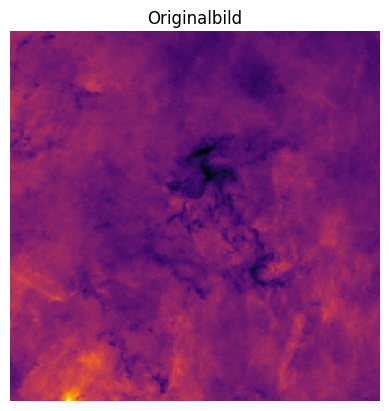

In [23]:
from astropy.io import fits
import numpy as np
import scipy
import matplotlib.pyplot as plt
from script.starremove import removestars
from script.cloud_detection import *


FITS_PATH = '../data/fits/PROMISE-Q1-8micron-filled-v0_3.fits'
# FITS_PATH = '../cnn/fits_for_annotation/box(50316.355, 6033.3671, 234.3168, 178.3296, 0.0).fits'
# FITS_PATH = '../data/fits/box47346.223_5974.1909_21.600045_21.600045_0.0.fits'

XSIZE: int = 512
YSIZE: int = 512
X: int = 49300
Y: int = 6000

# Open currimg and display info using memmap to not load the whole image into memory
imageHDU = fits.open(FITS_PATH, memmap=True, mode='denywrite')
imageHDU.info()

# Get display image as Numpy Array called data
data = np.array(imageHDU[0].data[Y:Y + YSIZE, X:X + XSIZE], dtype=np.float32)  # type: ignore
imageHDU.close()  # Close the file

plt.style.use({"image.origin": "lower", "image.interpolation": "nearest"})

# data = removestars(data)

# Display data
plt.imshow(data, cmap='inferno')  # nipy_spectral, inferno, plasma, magma, viridis <- all good
plt.axis('off')
plt.title('Originalbild')
plt.savefig("originaldata.eps", format="eps", bbox_inches="tight", pad_inches=0)

Mean: 104.69190216064453 Median: 104.4027099609375 Std: 10.54692554473877


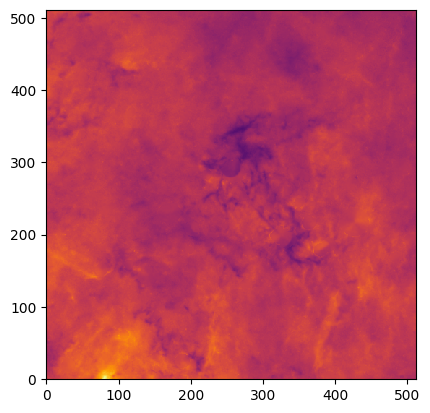

In [24]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print("Mean:", mean, "Median:", median, "Std:", std)

plt.imshow(data, cmap='inferno', interpolation='nearest', vmax=mean+10*std, vmin=0)

In [25]:
# plot maybe stars
from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data - median)
if sources:
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    norm = ImageNormalize(stretch=SqrtStretch()) # type: ignore
    plt.imshow(data, cmap='inferno', norm=norm)
    plt.plot(positions[:, 0], positions[:, 1], 'o', markerfacecolor='none', markeredgecolor='limegreen', markersize=4)

print((mean, median, std))

(104.69190216064453, 104.4027099609375, 10.54692554473877)


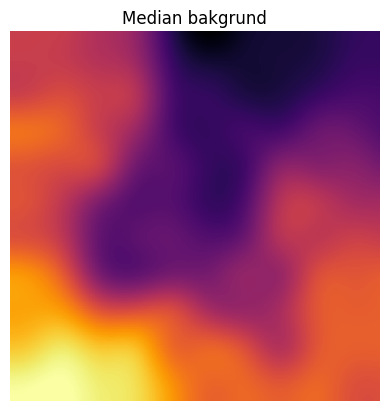

In [26]:
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip

sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
# bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip)

plt.imshow(bkg.background, cmap='inferno')
plt.title("Median bakgrund")
plt.axis('off')
plt.savefig("medianbackground.eps", format="eps", bbox_inches="tight", pad_inches=0)

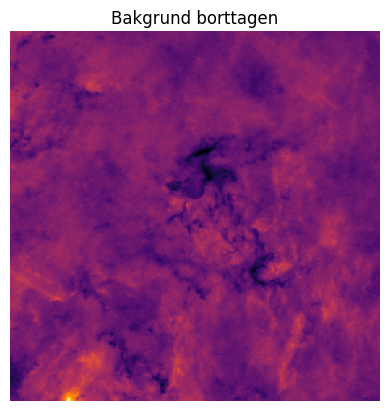

In [27]:
diff = data - bkg.background # type: ignore
diff = diff - np.min(diff) # normalize to 0
norm = ImageNormalize(stretch=SqrtStretch()) # type: ignore
plt.imshow(diff, cmap='inferno')
plt.title("Bakgrund borttagen")
plt.axis('off');
plt.savefig("medianbackgroundremoved.eps", format="eps", bbox_inches="tight", pad_inches=0)
# bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.1)
#background removed, really clean :O

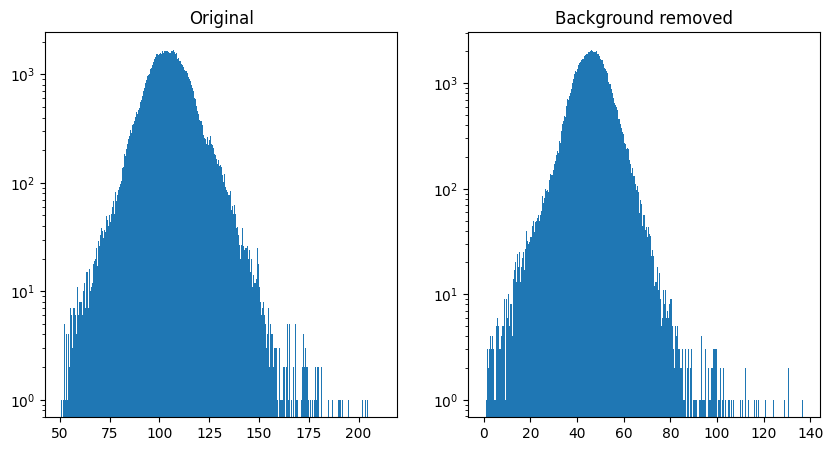

In [28]:
# plot histogram
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.hist(data.flatten(), bins=1000, log=True)
ax.title.set_text('Original')
ax = fig.add_subplot(1, 2, 2)
ax.hist(diff.flatten(), bins=1000, log=True)
ax.title.set_text('Background removed')

46.25557620662109 46.322808150159815 6.713619706166152
32.82833679428879


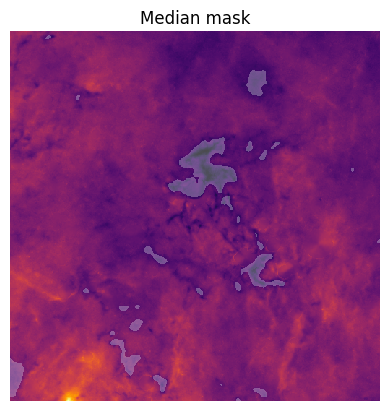

In [29]:
from matplotlib.colors import ListedColormap
from astropy.stats import sigma_clipped_stats
# same as in first.ipynb, just a test to see if results are better

# blur the image a little
gauss = scipy.ndimage.gaussian_filter(diff, sigma=3)
# create mask by thresholding
# threshold = np.percentile(gauss, 2)

mean, median, stddev = sigma_clipped_stats(gauss, sigma=3)
threshold = mean - 2 * stddev

print(mean, median, stddev)
print(threshold)

mask = np.where(gauss < threshold, True, False)

# mark areas in image
# norm = ImageNormalize(stretch=SqrtStretch()) # type: ignore
plt.imshow(data, cmap='inferno')
cmap1 = ListedColormap(['none', 'white'])
# plt.imshow(mask, cmap=cmap1, alpha=0.3)

# s = scipy.ndimage.generate_binary_structure(2,2)
labels, nlabels = scipy.ndimage.label(mask)
plt.imshow(mask, cmap=cmap1, alpha=0.3)
plt.title("Median mask")
plt.axis("off")
plt.savefig("medianmask.eps", format="eps", bbox_inches="tight", pad_inches=0)

Found objects: 22


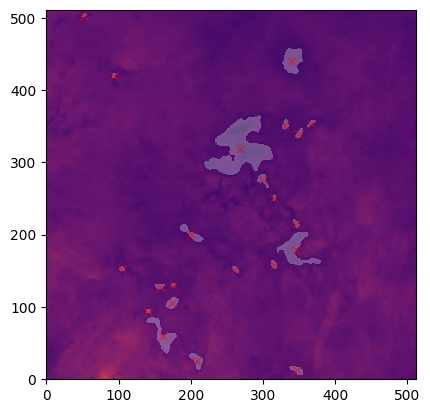

In [30]:
norm = ImageNormalize(stretch=SqrtStretch()) # type: ignore
plt.imshow(data, cmap='inferno', vmin=0, vmax=mean+50*stddev)

# sum the areas of mask with labels
dust_areas = np.array(scipy.ndimage.sum(mask, labels, range(0, nlabels+1)))

# remove small clouds
mask_small = dust_areas > 20

# remove clouds touching the edges of processed image
mask_edge = np.zeros(mask.shape, dtype=bool)
mask_edge[0:1, :] = True
mask_edge[:, 0:1] = True
mask_edge[data.shape[0]-1:data.shape[0], :] = True
mask_edge[:, data.shape[1]-1:data.shape[1]] = True
labels_touching_edge = np.unique(mask_edge*labels)

# remove clouds touching the black edges
objects_first = scipy.ndimage.find_objects(labels)
masked_data = mask*(data-1)+1

for cloud in range(0, nlabels):
    # if not np.all(masked_data[objects_first[cloud]]) or not (cloud+1) in labels_outside_overlap:
    if not np.all(masked_data[objects_first[cloud]]) or (cloud+1) in labels_touching_edge:
        mask_small[cloud+1] = False

# remove small clouds and edge clouds
remove_small_clouds = mask_small[labels.ravel()].reshape(labels.shape)
dust_areas_new = dust_areas[mask_small]

plt.imshow(remove_small_clouds, cmap=cmap1, alpha=0.3)

# unnecssary step, but I don't know how to do it otherwise
new_labels, new_nlabels = scipy.ndimage.label(remove_small_clouds)
print("Found objects:", new_nlabels)

mass_centers = scipy.ndimage.center_of_mass(data, new_labels, range(1, new_nlabels+1))
# plot mass centers
for center in mass_centers:
    plt.plot(center[1], center[0], 'rx', alpha=0.5)

In [31]:
objects = scipy.ndimage.find_objects(new_labels)

output = format_for_ouput(mass_centers, objects, new_labels, dust_areas_new, X, Y, "../data/")
print(output[0])

save_reg_and_csv(output, "catalog_test", "../data/")
# moved functions to cloud_detection.py

FileNotFoundError: [Errno 2] No such file or directory: '../../data/masks/347_12_ZuQzI2Q.npy'

3 {'x_center': 83, 'y_center': 128, 'approx_size': 49, 'box_x1': 80, 'box_x2': 88, 'box_y1': 125, 'box_y2': 133, 'mask_file': '83_128_MpP0GDM.npy'}


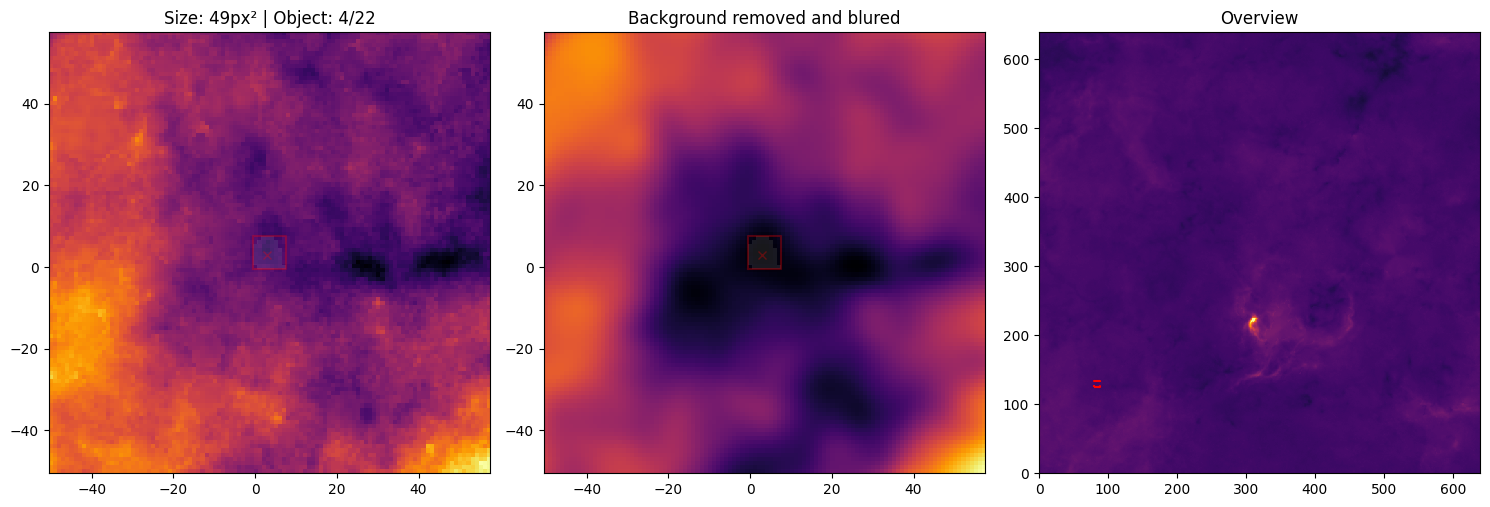

In [ ]:
#plot random object
import random
index = random.randint(0, len(output)-1)
# index = 0
padding = 50

while (output[index]["box_y1"]-Y-padding) < 0 or (output[index]["box_y2"]-Y+padding) > data.shape[0] or (output[index]["box_x1"]-X-padding) < 0 or (output[index]["box_x2"]-X+padding) > data.shape[1]:
    padding -= 1
    # print("Padding too big, set to 0")
    
print(index, output[index])

fig = plt.figure(figsize=(15, 5))

extent = (-padding-0.5, output[index]["box_x2"]+padding-output[index]["box_x1"]-0.5, -padding-0.5, output[index]["box_y2"]+padding-output[index]["box_y1"]-0.5)

rand_mask = np.load("../data/masks/"+output[index]["mask_file"])

for num in range(1,3):
    ax = fig.add_subplot(1, 3, num)

    if num == 1:
        ax.imshow(data[(output[index]["box_y1"]-Y-padding):(output[index]["box_y2"]-Y+padding), output[index]["box_x1"]-X-padding:output[index]["box_x2"]-X+padding], cmap='inferno', extent=extent)
        plt.title("Size: " + str(int(output[index]["approx_size"])) + "px² | Object: " + str(index+1) + "/" + str(len(output)))
    else:
        ax.imshow(gauss[(output[index]["box_y1"]-Y-padding):(output[index]["box_y2"]-Y+padding), output[index]["box_x1"]-X-padding:output[index]["box_x2"]-X+padding], cmap='inferno', extent=extent)
        plt.title("Background removed and blured")

    ax.imshow(rand_mask, cmap=cmap1, alpha=0.1)
    ax.plot(output[index]["x_center"]-output[index]["box_x1"], output[index]["y_center"]-output[index]["box_y1"], 'rx', alpha=0.3)
    ax.plot([-0.5, output[index]["box_x2"]-output[index]["box_x1"]-0.5, output[index]["box_x2"]-output[index]["box_x1"]-0.5, -0.5, -0.5], [-0.5, -0.5, output[index]["box_y2"]-output[index]["box_y1"]-0.5, output[index]["box_y2"]-output[index]["box_y1"]-0.5, -0.5], 'r-', alpha=0.3)



ax = fig.add_subplot(1, 3, 3)
ax.imshow(data, cmap='inferno', vmin=0, vmax=500)
ax.plot([output[index]["box_x1"]-X, output[index]["box_x2"]-X, output[index]["box_x2"]-X, output[index]["box_x1"]-X, output[index]["box_x1"]-X], [output[index]["box_y1"]-Y, output[index]["box_y1"]-Y, output[index]["box_y2"]-Y, output[index]["box_y2"]-Y, output[index]["box_y1"]-Y], 'r--')
plt.title("Overview")

fig.tight_layout()
plt.show()

0 22


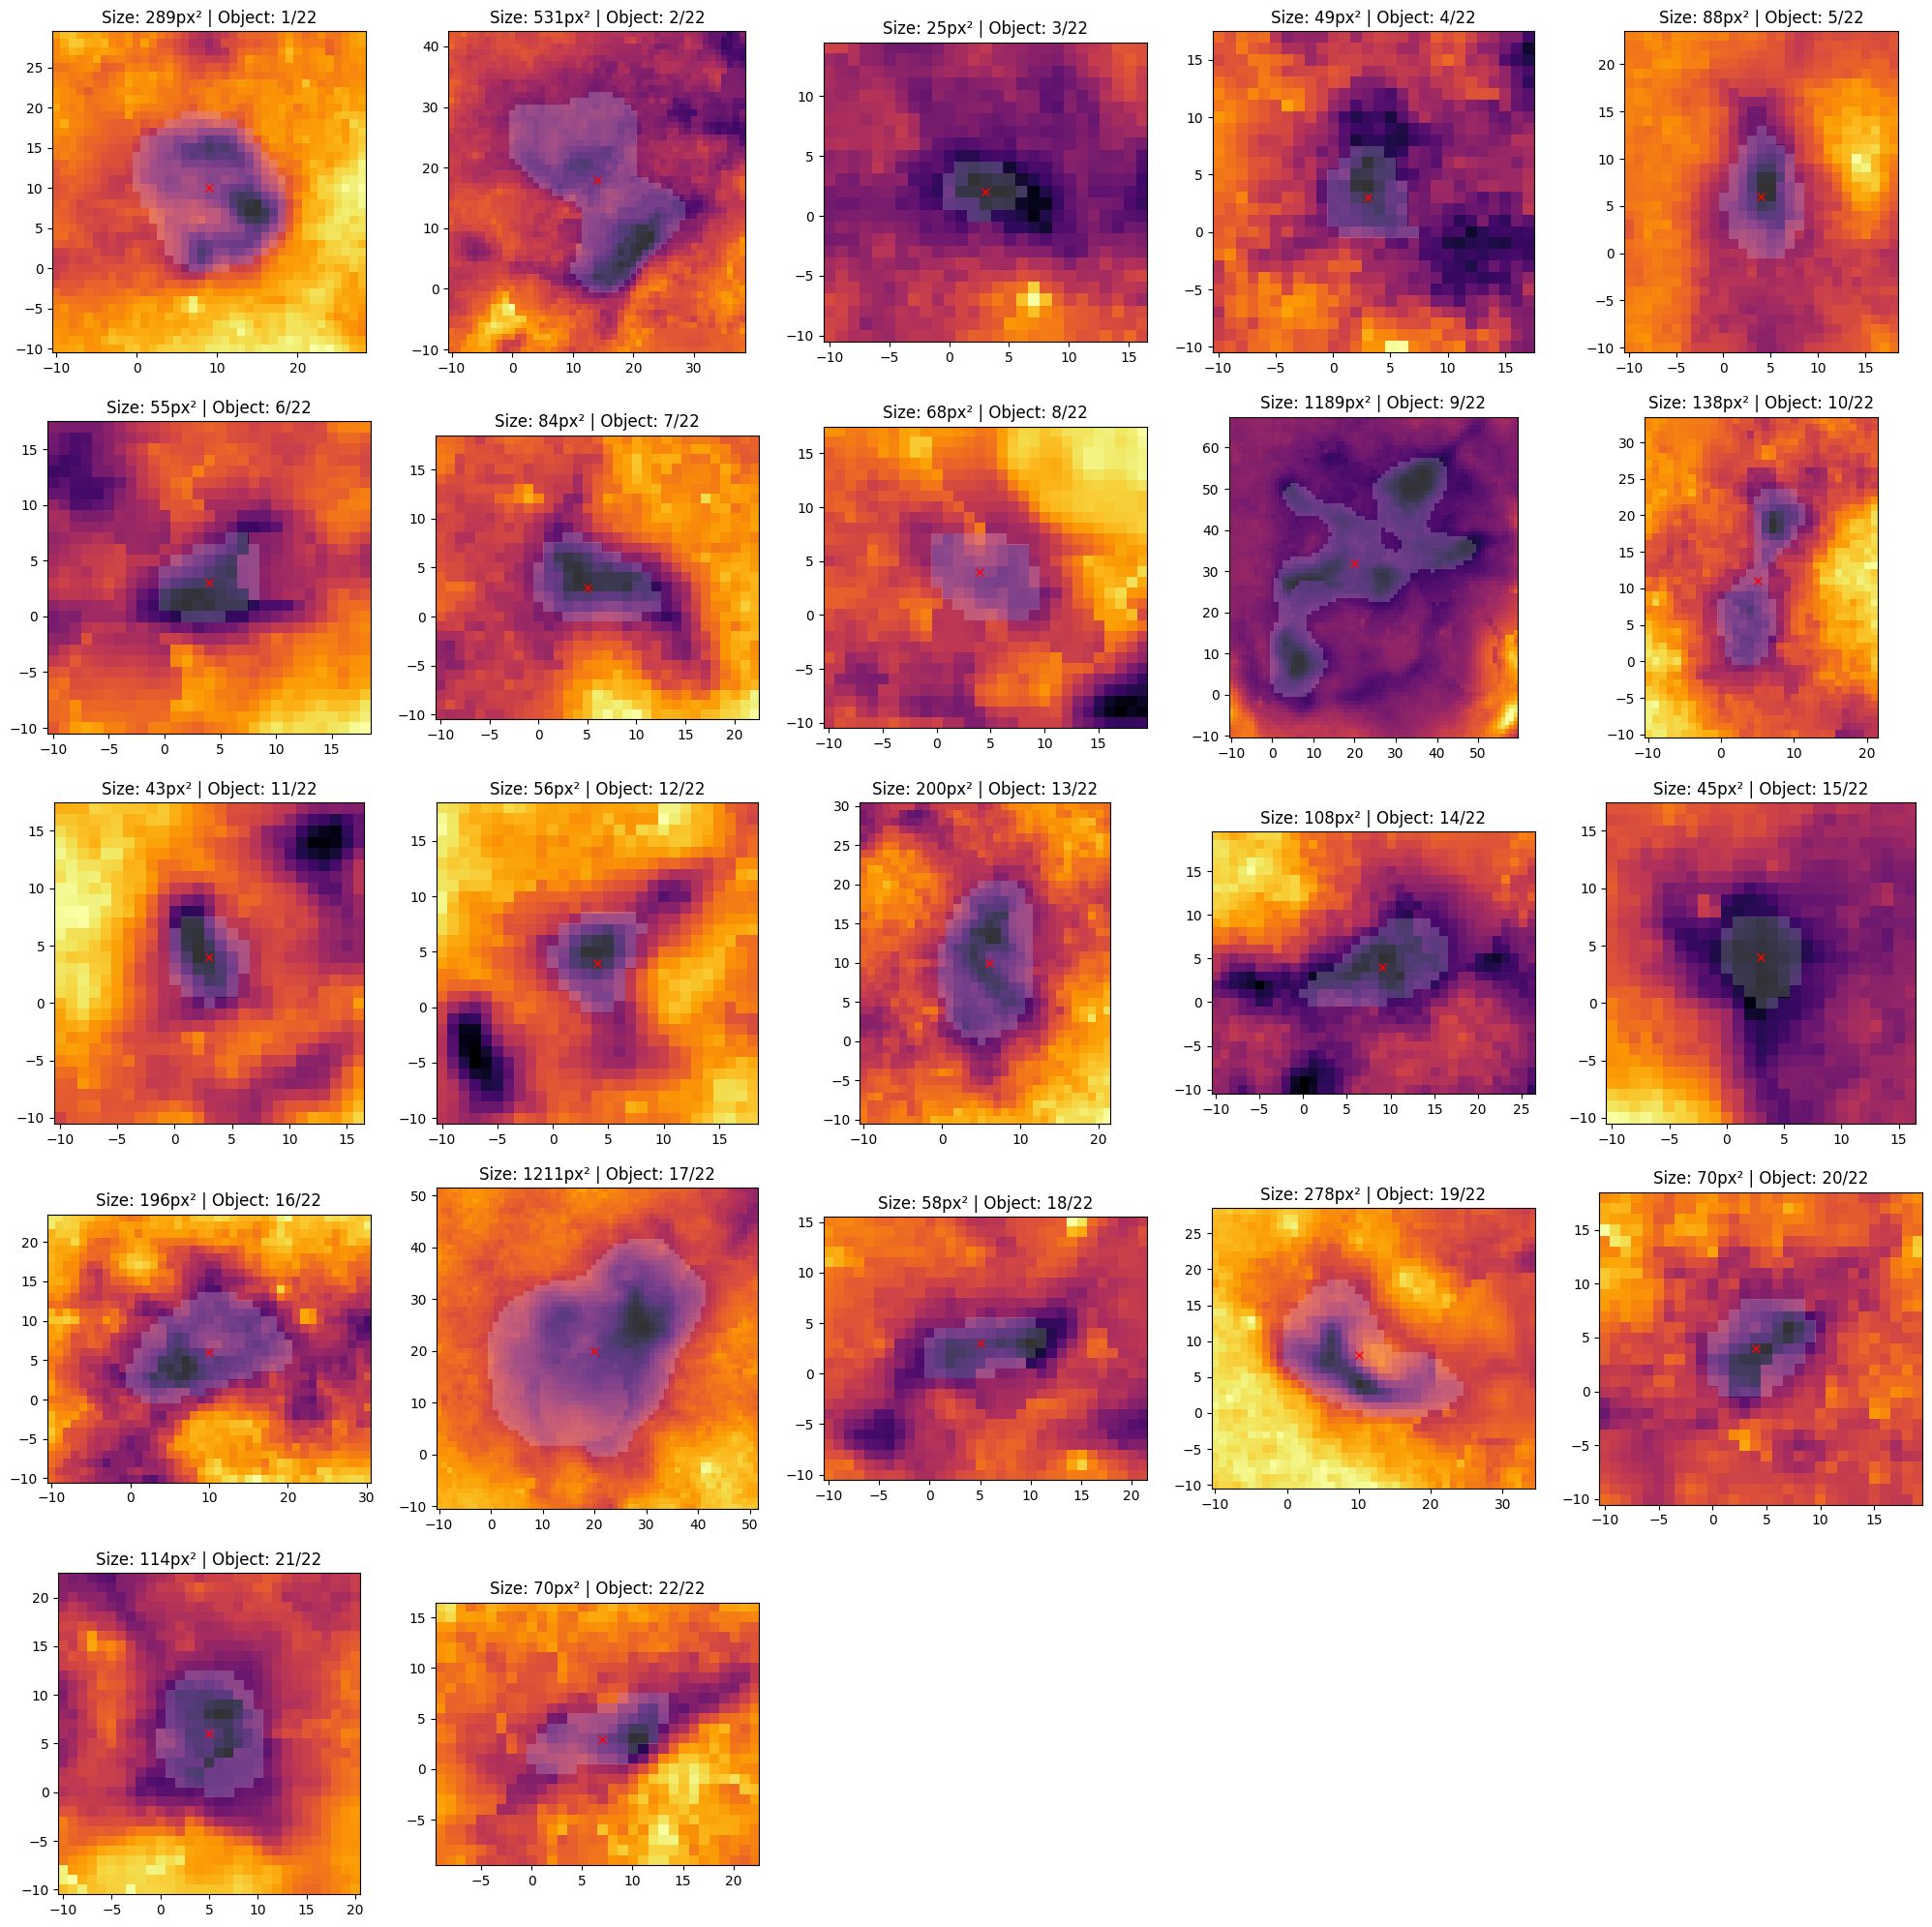

In [ ]:
# plot "count" random objects
count = 25

stop_range = len(output)-1-count
if stop_range < 0:
    stop_range = 0

start = random.randint(0, stop_range)

if start+count > len(output):
    count = len(output)-start

print(start,count)

fig = plt.figure(figsize=(25, 5*(count//5+1)))

for index in range(start,start+count):
    padding = 10
    ax = fig.add_subplot((count)//5+1, 5, index-start+1)
    rand_mask = np.load("../data/masks/"+output[index]["mask_file"])

    while (output[index]["box_y1"]-Y-padding) < 0 or (output[index]["box_y2"]-Y+padding) > data.shape[0] or (output[index]["box_x1"]-X-padding) < 0 or (output[index]["box_x2"]-X+padding) > data.shape[1]:
        padding -= 1

    extent = (-padding-0.5, output[index]["box_x2"]+padding-output[index]["box_x1"]-0.5, -padding-0.5, output[index]["box_y2"]+padding-output[index]["box_y1"]-0.5)
    
    ax.imshow(data[(output[index]["box_y1"]-Y-padding):(output[index]["box_y2"]-Y+padding), output[index]["box_x1"]-X-padding:output[index]["box_x2"]-X+padding], cmap='inferno', extent=extent)
    plt.title("Size: " + str(int(output[index]["approx_size"])) + "px² | Object: " + str(index+1) + "/" + str(len(output)))
    ax.imshow(rand_mask, cmap=cmap1, alpha=0.2)
    ax.plot(output[index]["x_center"]-output[index]["box_x1"], output[index]["y_center"]-output[index]["box_y1"], 'rx', alpha=1)
    